# KOMET Project Evaluation Report

![KOMET Project](https://projects.tib.eu/fileadmin/templates/komet/tib_projects_komet_1150.png)

## About KOMET

**KOMET** — *Kollaborative Anreicherung der Metadatenallmende zur Förderung eines diversen Open-Access-Ökosystems* (Collaborative Enrichment of the Metadata Commons to Foster a Diverse Open Access Ecosystem) — enhances metadata processes for independent, scholar-led Open Access journals. The project develops plugins and tools to improve article discoverability (https://projects.tib.eu/komet/en/). KOMET builds in part on its related project OPTIMETA (https://projects.tib.eu/optimeta/en/) and develops different tools and software to advance [open research information](https://barcelona-declaration.org/), including three OJS plugins:

- **PID Plugin**: Integrating validated persistent identifiers (ROR, IGSN, PIDINST, ConfIDent) into article metadata in OJS (https://github.com/GaziYucel/pidManager/)
- **Citations**: Structured citation metadata in OJS core (version 3.6, see details in https://www.youtube.com/watch?v=YX4y2k-eP_w; formely developed as a plugin at https://github.com/TIBHannover/citationManager) for capture and publication to the open citation graph via OpenCitations Crowdsourcing (https://github.com/opencitations/crowdsourcing)
- **Geo Plugin**: Geospatial and temporal metadata for location-based article discovery in OJS (https://github.com/TIBHannover/geoMetadata)
- **Janeway Plugin**: Geospatial and temporal metadata for location-based article discovery (https://github.com/GeoinformationSystems/janeway_geometadata)
- **OPTIMAP**: A central discovery page for geometadata-enabled scholarly works (https://optimap.science/)

The project outputs are available on GitHub (https://github.com/TIBHannover/optimetaCitations, https://github.com/TIBHannover/optimetaGeo, https://github.com/TIBHannover/optimeta-plugin-shared) and the team communicates via Mastodon (https://openbiblio.social/@komet).

This notebook is part of the KOMET work package on evaluation. It tracks the development and, as far as possible, contributions to the open metadata commons in the areas of citation metadata and geometadata. A [PDF version of this report](komet_report.pdf) is also available. The source of this notebook and all underlying data is available on GitHub (https://github.com/GeoinformationSystems/komet-report/).

## Data Sources

| Source | Purpose | Priority |
|--------|---------|----------|
| **OpenCitations** | Citation metadata contributions | Primary |
| **Wikidata** | Scholarly graph baseline & specific properties | Monitoring |


In [1]:
# Setup and imports (hidden in HTML export)
import komet_helpers as kh
from datetime import datetime
import json
import os
import time
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from IPython.display import HTML, display, Markdown

# Set matplotlib style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 5)
plt.rcParams['font.size'] = 11

# Load or create timeline for tracking metrics over time
timeline = kh.load_timeline()
report_timestamp = kh.format_timestamp()

In [2]:
# Table display helper for HTML and PDF export
from IPython.display import display, HTML, Markdown

def show_table(df, caption=None, index=False):
    """
    Display DataFrame as HTML table with optional caption.
    For PDF export via markdown, tables are converted by nbconvert.
    Links in cells should use HTML <a> tags for proper rendering.
    """
    html = df.to_html(escape=False, index=index, classes='dataframe table')
    if caption:
        html = f"<p><strong>{caption}</strong></p>\n{html}"
    display(HTML(html))


In [3]:
# Report metadata
last_updated = timeline["metadata"].get("last_updated", "Never")
last_updated_str = last_updated[:19].replace("T", " ") if last_updated and last_updated != "Never" else "Never"

display(Markdown(f'''
**Report Information**

| Field | Value |
|-------|-------|
| Generated | {report_timestamp[:19].replace("T", " ")} UTC |
| Timeline Version | {timeline["metadata"].get("version", "1.0")} |
| Last Updated | {last_updated_str} UTC |
| Update Frequency | Monthly (1st of each month) |
'''))



**Report Information**

| Field | Value |
|-------|-------|
| Generated | 2026-02-03 13:53:51 UTC |
| Timeline Version | 2.0 |
| Last Updated | 2026-02-03 13:44:41 UTC |
| Update Frequency | Monthly (1st of each month) |


---

## 1. Wikidata Analysis

### 1.1 P1343 (Described by Source) - Limited Reach

The original KOMET proposal mentioned using **P1343 ("described by source")** to mark contributions from project plugins. However, our analysis reveals this property has **very limited usage** for scholarly articles. Instead, P1343 is primarily used for encyclopedias/reference works and is not among widely used properties for citations in Wikidata. It is also not included in any Wikidata export, because the primary target for citation data contributions has shifted to OpenCitations.

In [4]:
# Query P1343 usage (hidden - data fetching)
p1343_count = kh.count_p1343_scholarly_articles()
komet_provenance = kh.search_komet_provenance_wikidata()

# Log to timeline
if p1343_count is not None:
    kh.add_observation(
        timeline, "wikidata.p1343_scholarly_count", p1343_count, "wikidata",
        notes="P1343 rarely used for scholarly articles",
        metric_name="P1343 Scholarly Articles",
        metric_description="Scholarly articles with 'described by source' property"
    )

kh.add_observation(
    timeline, "wikidata.komet_provenance_count", len(komet_provenance) if komet_provenance else 0,
    "wikidata", notes="Items with KOMET in P1343 source",
    metric_name="KOMET Provenance Items",
    metric_description="Wikidata items with KOMET as source"
)

Query timed out after 60s


False

In [5]:
# Display P1343 findings
p1343_display = p1343_count if p1343_count is not None else "Query failed"
komet_prov_count = len(komet_provenance) if komet_provenance else 0

display(Markdown(f'''
### P1343 Limitation Finding

| Metric | Value |
|--------|------:|
| Scholarly articles with P1343 | **{p1343_display}** |
| Total scholarly articles in Wikidata | ~37,000,000 |
| Items referencing KOMET as source | {komet_prov_count} |

**Conclusion:** P1343 is not suitable for tracking KOMET contributions.
'''))



### P1343 Limitation Finding

| Metric | Value |
|--------|------:|
| Scholarly articles with P1343 | **14** |
| Total scholarly articles in Wikidata | ~37,000,000 |
| Items referencing KOMET as source | 0 |

**Conclusion:** P1343 is not suitable for tracking KOMET contributions.


### 1.2 P2860 (Cites Work) - Partner Journal Baseline

We track **P2860 (cites work)** relationships for KOMET partner journals to establish a baseline for measuring impact over time. These are OJS-based journals from academic institutions that have originally committed to testing the KOMET plugins.
The following tables summarize the current state of citations from these journals only in Wikidata.

In [6]:
# Fetch partner journal data (hidden - data fetching)
partner_journals = kh.get_journals_with_wikidata()
journal_stats = []

for journal in partner_journals:
    qid = journal["wikidata_qid"]
    name = journal["name"]
    
    article_count = kh.count_journal_articles_wikidata(qid)
    citation_count = kh.count_journal_citations_p2860(qid)
    
    stats = {
        "name": name,
        "partner": journal.get("partner", "Unknown"),
        "qid": qid,
        "wikidata_articles": article_count or 0,
        "wikidata_citations_p2860": citation_count or 0,
        "baseline_2022": journal.get("baseline_2022", {})
    }
    journal_stats.append(stats)
    
    # Log to timeline
    kh.add_journal_observation(timeline, qid, "articles", article_count,
                               journal_name=name, partner=journal.get("partner"))
    kh.add_journal_observation(timeline, qid, "citations_p2860", citation_count,
                               journal_name=name, partner=journal.get("partner"))
    time.sleep(1)  # Rate limiting

# Calculate totals
total_articles = sum(s['wikidata_articles'] for s in journal_stats)
total_citations = sum(s['wikidata_citations_p2860'] for s in journal_stats)

In [7]:
# Display partner journal statistics as interactive table
df_journals = pd.DataFrame([{
    'Journal': s['name'],
    'Partner': s['partner'],
    'Wikidata QID': f'<a href="https://www.wikidata.org/wiki/{s["qid"]}" target="_blank">{s["qid"]}</a>',
    'Articles': s['wikidata_articles'],
    'Citations (P2860)': s['wikidata_citations_p2860']
} for s in journal_stats])

display(Markdown(f'''
#### Partner Journal Wikidata Statistics

**Total journals tracked:** {len(journal_stats)} | **Total articles:** {total_articles} | **Total citations:** {total_citations}
'''))

show_table(df_journals)



#### Partner Journal Wikidata Statistics

**Total journals tracked:** 15 | **Total articles:** 42 | **Total citations:** 2


Journal,Partner,Wikidata QID,Articles,Citations (P2860)
Journal of South Asian Linguistics,KIM Universität Konstanz,Q122948152,0,0
Free Neuropathology,WWU Münster,Q108455809,0,0
Jahrbuch für Christliche Sozialwissenschaften,WWU Münster,Q1678617,0,0
Journal für Kulturpflanzen,Julius Kühn-Institut,Q1455822,0,0
VITIS - Journal of Grapevine Research,Julius Kühn-Institut,Q15756080,0,0
Journal of Applied Botany and Food Quality,Julius Kühn-Institut,Q15764825,0,0
Francia-Recensio,heiJOURNALS Heidelberg,Q101247086,0,0
Heidelberger Beiträge zum Finanz- und Steuerrecht,heiJOURNALS Heidelberg,Q105103105,0,0
Informationspraxis,heiJOURNALS Heidelberg,Q46478422,28,2
International Journal of Dream Research,heiJOURNALS Heidelberg,Q96332444,0,0


### 1.3 Comparison with 2022 Baseline

The 2022 baseline data allows tracking changes in Wikidata coverage over time.

In [8]:
# Create comparison table
comparison_data = []
for s in journal_stats:
    baseline = s.get('baseline_2022', {})
    baseline_art = baseline.get('wikidata_articles', 0)
    current_art = s['wikidata_articles']
    change = current_art - baseline_art
    
    comparison_data.append({
        'Journal': s['name'][:40] + ('...' if len(s['name']) > 40 else ''),
        '2022 Articles': baseline_art,
        'Current Articles': current_art,
        'Change': f"+{change}" if change >= 0 else str(change),
        'OpenAlex (2022)': baseline.get('openalex', 'N/A')
    })

df_comparison = pd.DataFrame(comparison_data)

display(Markdown('#### 2022 Baseline vs Current Wikidata Coverage'))
show_table(df_comparison)


#### 2022 Baseline vs Current Wikidata Coverage

Journal,2022 Articles,Current Articles,Change,OpenAlex (2022)
Journal of South Asian Linguistics,0,0,+0,0
Free Neuropathology,0,0,+0,0
Jahrbuch für Christliche Sozialwissensch...,0,0,+0,850
Journal für Kulturpflanzen,0,0,+0,558
VITIS - Journal of Grapevine Research,0,0,+0,1762
Journal of Applied Botany and Food Quali...,3,0,-3,419
Francia-Recensio,1,0,-1,1096
Heidelberger Beiträge zum Finanz- und St...,0,0,+0,0
Informationspraxis,55,28,-27,43
International Journal of Dream Research,0,0,+0,352


### 1.4 Observations

The comparison between Wikidata coverage and OpenAlex data reveals significant insights about the current state of metadata in the open knowledge commons.

In [9]:
# Analyze and display key observations
active_journals = [s for s in journal_stats if s['wikidata_articles'] > 0]
journals_with_citations = [s for s in journal_stats if s['wikidata_citations_p2860'] > 0]

# Find journals with significant OpenAlex but no Wikidata
gap_journals = []
for s in journal_stats:
    baseline = s.get('baseline_2022', {})
    openalex = baseline.get('openalex', 0)
    if openalex and openalex > 100 and s['wikidata_articles'] == 0:
        gap_journals.append({'name': s['name'], 'openalex': openalex, 'wikidata': s['wikidata_articles']})

# Calculate total OpenAlex coverage
total_openalex = sum(s.get('baseline_2022', {}).get('openalex', 0) or 0 for s in journal_stats)
coverage_ratio = (total_articles / total_openalex * 100) if total_openalex > 0 else 0

# Get specific journal stats
info_praxis = next((s for s in journal_stats if s['qid'] == 'Q46478422'), None)
itdb = next((s for s in journal_stats if s['qid'] == 'Q107074231'), None)

# Display key findings using markdown (works in both HTML and PDF)
display(Markdown(f'''
### Key Findings

| Metric | Value |
|--------|-------|
| **Active Journals in Wikidata** | {len(active_journals)} of {len(journal_stats)} journals have articles indexed |
| **Wikidata vs OpenAlex Gap** | {coverage_ratio:.1f}% Wikidata coverage of OpenAlex articles |


**Informationspraxis** (Q46478422) leads with {info_praxis['wikidata_articles'] if info_praxis else 0} articles and {info_praxis['wikidata_citations_p2860'] if info_praxis else 0} citation relationships — the only journal with P2860 data.
**{len(gap_journals)} journals** have significant OpenAlex coverage but zero Wikidata presence.
'''))



### Key Findings

| Metric | Value |
|--------|-------|
| **Active Journals in Wikidata** | 2 of 15 journals have articles indexed |
| **Wikidata vs OpenAlex Gap** | 0.8% Wikidata coverage of OpenAlex articles |


**Informationspraxis** (Q46478422) leads with 28 articles and 2 citation relationships — the only journal with P2860 data.
**8 journals** have significant OpenAlex coverage but zero Wikidata presence.


In [10]:
# Display the gap analysis table
if gap_journals:
    gap_df = pd.DataFrame(gap_journals)
    gap_df.columns = ['Journal', 'OpenAlex Articles', 'Wikidata Articles']
    gap_df = gap_df.sort_values('OpenAlex Articles', ascending=False)
    show_table(gap_df)


Journal,OpenAlex Articles,Wikidata Articles
VITIS - Journal of Grapevine Research,1762,0
Francia-Recensio,1096,0
Jahrbuch für Christliche Sozialwissenschaften,850,0
Journal für Kulturpflanzen,558,0
Journal of Applied Botany and Food Quality,419,0
International Journal of Dream Research,352,0
Archäologischer Anzeiger,224,0
Journal of Spatial Information Science,201,0


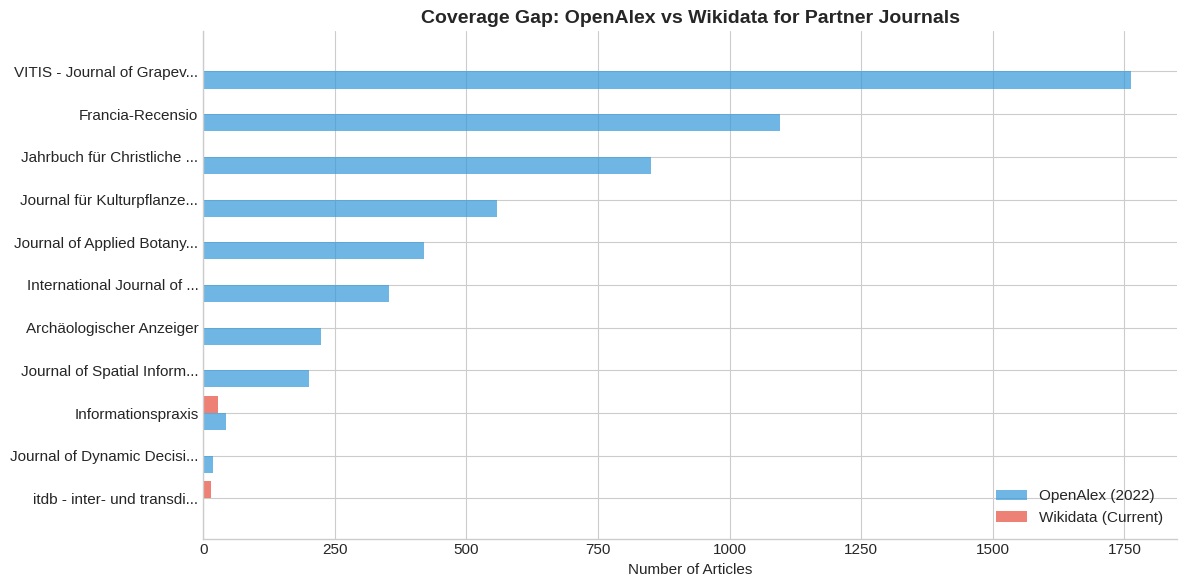

In [11]:
# Visualization: Coverage gap chart
fig, ax = plt.subplots(figsize=(12, 6))

# Prepare data for visualization
viz_data = []
for s in journal_stats:
    baseline = s.get('baseline_2022', {})
    openalex = baseline.get('openalex', 0) or 0
    if openalex > 0 or s['wikidata_articles'] > 0:
        viz_data.append({
            'name': s['name'][:25] + ('...' if len(s['name']) > 25 else ''),
            'openalex': openalex,
            'wikidata': s['wikidata_articles']
        })

viz_df = pd.DataFrame(viz_data).sort_values('openalex', ascending=True)

y_pos = range(len(viz_df))
ax.barh(y_pos, viz_df['openalex'], height=0.4, label='OpenAlex (2022)', color='#3498db', alpha=0.7)
ax.barh([y + 0.4 for y in y_pos], viz_df['wikidata'], height=0.4, label='Wikidata (Current)', color='#e74c3c', alpha=0.7)

ax.set_yticks([y + 0.2 for y in y_pos])
ax.set_yticklabels(viz_df['name'])
ax.set_xlabel('Number of Articles')
ax.set_title('Coverage Gap: OpenAlex vs Wikidata for Partner Journals', fontsize=14, fontweight='bold')
ax.legend(loc='lower right')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

display(HTML('<p style="font-size: 0.9em; color: #666;"><em>Figure 1: The gap between OpenAlex coverage and Wikidata presence demonstrates the opportunity for KOMET to enrich the metadata commons.</em></p>'))

### 1.5 Discussion

The data shows a stark contrast between OpenAlex coverage (thousands of articles) and Wikidata presence (near zero for most journals). This demonstrates the gap in open research information that KOMET aims to address, even though Wikidata is not the primary output database for citation information anymore. This gap exists because there is no automated pipeline. Unlike OpenAlex, which aggregates metadata from multiple sources, Wikidata requires explicit contributions, often through significant manual effort. The lack of tools for OJS-based journals to publish structured citation metadata means that many articles remain unrepresented and disconnected in the open knowledge graph and major metadata infrastructures, and subsequently that the impact of independent journals remains invisible.

KOMET plugins can help bridge this gap by automating metadata publication from OJS to open infrastructures like OpenCitations, making the work of independent journals more visible and connected.

---

## 2. OpenCitations

### 2.1 OpenCitations Crowdsourcing Analysis

**OpenCitations is the primary target platform** for KOMET citation metadata contributions.

The crowdsourcing repository (https://github.com/opencitations/crowdsourcing) allows trusted agents to contribute citation metadata via GitHub Issues.

In [12]:
# Fetch OpenCitations data (hidden - data fetching)
github_token = os.environ.get('GITHUB_TOKEN')
all_issues = kh.get_all_opencitations_issues(token=github_token)
summary = kh.summarize_opencitations_contributions(all_issues)

# Filter KOMET contributions
komet_issues = kh.filter_komet_contributions(all_issues)
komet_summary = kh.summarize_opencitations_contributions(komet_issues) if komet_issues else {'total_issues': 0, 'status_breakdown': {}}

successful = komet_summary['status_breakdown'].get('done', 0)
pending = komet_summary['status_breakdown'].get('to_be_processed', 0)
invalid = komet_summary['status_breakdown'].get('invalid', 0)

# Log to timeline
kh.add_observation(timeline, "opencitations.total_issues", len(all_issues), "opencitations",
                   metric_name="Total Crowdsourcing Issues")
kh.add_observation(timeline, "opencitations.komet_issues", len(komet_issues), "opencitations",
                   metric_name="KOMET Issues")
kh.add_observation(timeline, "opencitations.komet_done", successful, "opencitations",
                   metric_name="KOMET Successful")
kh.add_observation(timeline, "opencitations.komet_pending", pending, "opencitations",
                   metric_name="KOMET Pending")
kh.add_observation(timeline, "opencitations.komet_invalid", invalid, "opencitations",
                   metric_name="KOMET Invalid")

False

In [13]:
# Display OpenCitations summary
status_breakdown = summary['status_breakdown']

display(Markdown(f'''
### OpenCitations Crowdsourcing Overview

#### All Crowdsourcing Activity

**Total submissions: {summary["total_issues"]}**

| Status | Count |
|--------|------:|
''' + '\n'.join([f'| {status} | {count} |' for status, count in sorted(status_breakdown.items(), key=lambda x: -x[1])]) + f'''

#### KOMET Contributions

**Total KOMET submissions: {komet_summary["total_issues"]}**

| Status | Count |
|--------|------:|
| Successful | {successful} |
| Pending | {pending} |
| Invalid | {invalid} |**Funding**: BMBFTR (German Federal Ministry of Education and Research)  

'''))



### OpenCitations Crowdsourcing Overview

#### All Crowdsourcing Activity

**Total submissions: 15**

| Status | Count |
|--------|------:|
| invalid | 11 |
| unknown | 2 |
| done | 1 |
| to_be_processed | 1 |

#### KOMET Contributions

**Total KOMET submissions: 4**

| Status | Count |
|--------|------:|
| Successful | 0 |
| Pending | 0 |
| Invalid | 4 |**Funding**: BMBFTR (German Federal Ministry of Education and Research)  



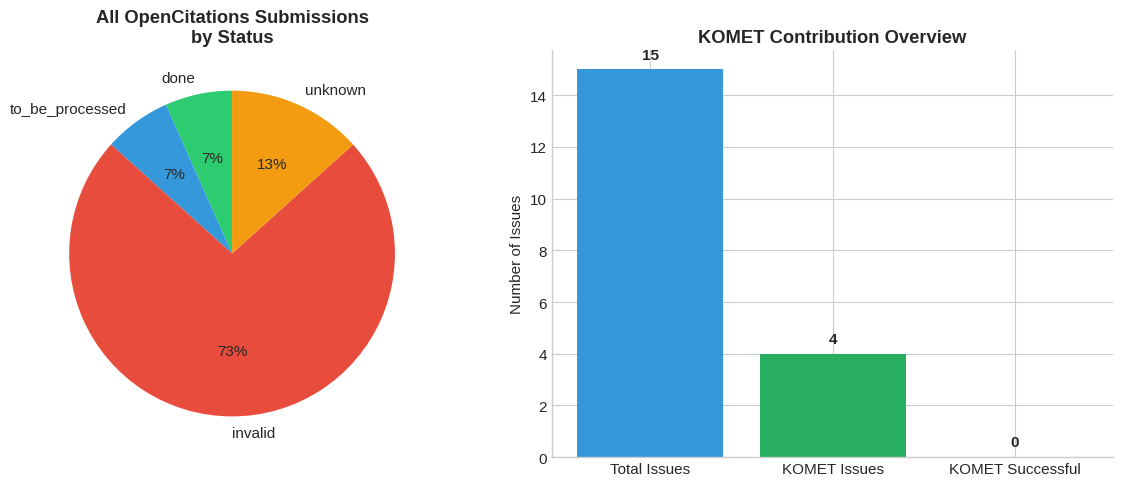

In [14]:
# Visualization: OpenCitations status breakdown
if summary['status_breakdown']:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Pie chart for all issues
    statuses = list(summary['status_breakdown'].keys())
    counts = list(summary['status_breakdown'].values())
    colors = ['#2ecc71', '#3498db', '#e74c3c', '#f39c12', '#9b59b6']
    
    ax1.pie(counts, labels=statuses, autopct='%1.0f%%', colors=colors[:len(statuses)], startangle=90)
    ax1.set_title('All OpenCitations Submissions\nby Status', fontweight='bold')
    
    # Bar chart for KOMET vs total
    categories = ['Total Issues', 'KOMET Issues', 'KOMET Successful']
    values = [summary['total_issues'], komet_summary['total_issues'], successful]
    bar_colors = ['#3498db', '#27ae60', '#2ecc71']
    
    bars = ax2.bar(categories, values, color=bar_colors)
    ax2.set_ylabel('Number of Issues')
    ax2.set_title('KOMET Contribution Overview', fontweight='bold')
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    
    # Add value labels on bars
    for bar, val in zip(bars, values):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3, str(val), 
                 ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    display(HTML('<p style="font-size: 0.9em; color: #666;"><em>Figure 2: OpenCitations crowdsourcing activity breakdown showing KOMET\'s contribution share.</em></p>'))

In [15]:
# Display KOMET contributions table
if komet_issues:
    komet_table_data = []
    for issue in komet_issues:
        parsed = kh.parse_opencitations_issue(issue)
        komet_table_data.append({
            'Issue': f'<a href="{parsed["url"]}" target="_blank">#{parsed["issue_number"]}</a>',
            'Title': parsed['title'][:50] + ('...' if len(parsed['title']) > 50 else ''),
            'Status': parsed['status'],
            'Created': parsed['created_at'][:10],
            'Creator': parsed['creator']
        })
    
    df_komet = pd.DataFrame(komet_table_data)
    display(Markdown(f'''
#### KOMET Software Contributions

*Contributors tracked: {", ".join(kh.KOMET_CONTRIBUTORS)}*
'''))
    show_table(df_komet)
else:
    display(Markdown('*No KOMET contributions found yet.*'))



#### KOMET Software Contributions

*Contributors tracked: GaziYucel*


Issue,Title,Status,Created,Creator
#6,deposit localhost doi:10.1234/37fs2v66,invalid,2025-10-10,GaziYucel
#5,deposit localhost doi:10.1234/37fs2v66,invalid,2025-10-09,GaziYucel
#4,deposit localhost doi:10.1234/37fs2v66,invalid,2025-10-09,GaziYucel
#3,deposit localhost doi:10.0000/1rjphk47,invalid,2025-03-27,GaziYucel
#2,Add GaziYucel to whitelist.txt,rejected,2023-04-04,GaziYucel


### 2.2 OpenCitations Index - Partner Journal Coverage

The [OpenCitations Index](https://opencitations.net/index) contains citation data from multiple sources. 
We query the [OpenCitations API](https://api.opencitations.net/) to check how many citations exist for articles published in KOMET partner journals.

In [16]:
# Fetch OpenCitations Index statistics for partner journals (hidden - data fetching)
# Uses the venue-citation-count API endpoint

oc_index_stats = []

for journal in partner_journals:
    qid = journal["wikidata_qid"]
    name = journal["name"]
    
    # Get ISSN from Wikidata
    meta = kh.get_journal_metadata_wikidata(qid)
    issn = meta.get("issn")
    
    oc_citations = None
    if issn:
        oc_citations = kh.get_journal_citation_count_opencitations(issn)
        time.sleep(0.5)  # Rate limiting (180 req/min)
    
    oc_index_stats.append({
        "name": name,
        "qid": qid,
        "issn": issn,
        "oc_citations": oc_citations
    })
    
    # Log to timeline
    if oc_citations is not None:
        kh.add_observation(
            timeline, f"opencitations.index.{qid}.citations", oc_citations, 
            "opencitations_index",
            metric_name=f"OC Index Citations ({name[:20]})",
            metric_description=f"Citations in OpenCitations Index for {name}"
        )

# Calculate totals
total_oc_citations = sum(s['oc_citations'] or 0 for s in oc_index_stats)
journals_with_issn = sum(1 for s in oc_index_stats if s['issn'])
journals_with_oc_data = sum(1 for s in oc_index_stats if s['oc_citations'] and s['oc_citations'] > 0)

In [17]:
# Display OpenCitations Index statistics
df_oc_index = pd.DataFrame([{
    'Journal': s['name'][:40] + ('...' if len(s['name']) > 40 else ''),
    'ISSN': f'<a href="https://portal.issn.org/resource/ISSN/{s["issn"]}" target="_blank">{s["issn"]}</a>' if s['issn'] else '—',
    'Citations in OC Index': s['oc_citations'] if s['oc_citations'] is not None else '—'
} for s in oc_index_stats])

display(Markdown(f"""
**Summary:** {journals_with_issn} journals have ISSNs | {journals_with_oc_data} have citations in OpenCitations | **Total citations: {total_oc_citations}**
"""))

show_table(df_oc_index)

display(Markdown("""
**Note**: Citation counts are retrieved from the [OpenCitations Index API](https://api.opencitations.net/index/v2). 
A count of 0 means the journal's articles are not yet indexed in OpenCitations, representing an opportunity for KOMET contributions.
"""))


**Summary:** 13 journals have ISSNs | 0 have citations in OpenCitations | **Total citations: 0**


Journal,ISSN,Citations in OC Index
Journal of South Asian Linguistics,1947-8232,0
Free Neuropathology,2699-4445,0
Jahrbuch für Christliche Sozialwissensch...,—,—
Journal für Kulturpflanzen,1867-0911,0
VITIS - Journal of Grapevine Research,0042-7500,0
Journal of Applied Botany and Food Quali...,0066-1759,0
Francia-Recensio,2425-3510,0
Heidelberger Beiträge zum Finanz- und St...,—,—
Informationspraxis,2297-3249,0
International Journal of Dream Research,1866-7953,0



**Note**: Citation counts are retrieved from the [OpenCitations Index API](https://api.opencitations.net/index/v2). 
A count of 0 means the journal's articles are not yet indexed in OpenCitations, representing an opportunity for KOMET contributions.


---

## 3. Partner Journal Overview

Complete overview of all KOMET collaboration partners and their journals. The partner list originates from the OPTIMETA project (https://projects.tib.eu/optimeta/en/).

In [18]:
# Display all partner journals with links
all_journals = kh.COLLABORATION_PARTNERS["journals"]
journals_without_wd = kh.COLLABORATION_PARTNERS.get("journals_without_wikidata", [])

partner_table = [{
    'Journal': j['name'],
    'Partner Organization': j.get('partner', 'N/A'),
    'Website': f'<a href="{j.get("url", "#")}" target="_blank">Link</a>' if j.get('url') else 'N/A',
    'Wikidata': f'<a href="https://www.wikidata.org/wiki/{j["wikidata_qid"]}" target="_blank">{j["wikidata_qid"]}</a>',
    'OJS Version': j.get('ojs_version', 'N/A')
} for j in all_journals]

df_partners = pd.DataFrame(partner_table)

display(Markdown(f'''
**Summary:** {len(all_journals)} journals with Wikidata entries | {len(journals_without_wd)} journals pending Wikidata creation

#### Journals with Wikidata Entries
'''))

show_table(df_partners)



**Summary:** 15 journals with Wikidata entries | 7 journals pending Wikidata creation

#### Journals with Wikidata Entries


Journal,Partner Organization,Website,Wikidata,OJS Version
Journal of South Asian Linguistics,KIM Universität Konstanz,Link,Q122948152,3.3.0.14
Free Neuropathology,WWU Münster,Link,Q108455809,3.3.0.13
Jahrbuch für Christliche Sozialwissenschaften,WWU Münster,Link,Q1678617,3.3.0.13
Journal für Kulturpflanzen,Julius Kühn-Institut,Link,Q1455822,3.3.0.8
VITIS - Journal of Grapevine Research,Julius Kühn-Institut,Link,Q15756080,3.3.0.8
Journal of Applied Botany and Food Quality,Julius Kühn-Institut,Link,Q15764825,3.3.0.8
Francia-Recensio,heiJOURNALS Heidelberg,Link,Q101247086,3.2.1.4
Heidelberger Beiträge zum Finanz- und Steuerrecht,heiJOURNALS Heidelberg,Link,Q105103105,3.2.1.4
Informationspraxis,heiJOURNALS Heidelberg,Link,Q46478422,3.2.1.4
International Journal of Dream Research,heiJOURNALS Heidelberg,Link,Q96332444,3.2.1.4


In [19]:
# Journals without Wikidata
if journals_without_wd:
    pending_list = '\n'.join([f'- {j["name"]} ({j.get("partner", "N/A")})' for j in journals_without_wd])
    display(Markdown(f'''
#### Journals Pending Wikidata Creation

{pending_list}
'''))



#### Journals Pending Wikidata Creation

- Formal Approaches to South Asian Languages (KIM Konstanz)
- Journal of Historical Syntax (KIM Konstanz)
- KIM Kompakt (KIM Konstanz)
- The Byzantine Review (WWU Münster)
- Mittelalter Digital (WWU Münster)
- Volcanica (Independent)
- GEUS Bulletin (Independent)


In [20]:
# Display publishing platforms
platforms = kh.COLLABORATION_PARTNERS.get("platforms", [])
if platforms:
    platform_list = '\n'.join([f'- [{p["name"]}]({p["url"]})' for p in platforms])
    display(Markdown(f'''
#### Publishing Platforms

{platform_list}
'''))



#### Publishing Platforms

- [KIM - Universität Konstanz](https://www.kim.uni-konstanz.de/)
- [WWU E-Journals Münster](https://www.uni-muenster.de/Ejournals/)
- [e-journals Julius Kühn-Institut](https://ojs.openagrar.de)
- [heiJOURNALS Heidelberg](https://journals.ub.uni-heidelberg.de)
- [TIB Open Publishing](https://www.tib-op.org/)
- [ZHB Luzern](https://www.zhbluzern.ch/)


---

## 4. Summary & Key Metrics

In [21]:
# Compile and save report data (hidden)
# Note: geo_stats will be populated later in section 5, timeline saved at end
report_data = {
    "report_timestamp": kh.format_timestamp(),
    "platform_priority": {
        "primary": "OpenCitations",
        "secondary": "Wikidata (monitoring only)",
        "planned": "OpenAIRE"
    },
    "wikidata": {
        "p1343_scholarly_count": p1343_count,
        "p1343_limitation_note": "P1343 rarely used for scholarly articles; not suitable for tracking",
        "komet_provenance_items": len(komet_provenance) if komet_provenance else 0,
        "partner_journals_tracked": len(partner_journals),
        "partner_journals_total_articles": total_articles,
        "partner_journals_total_citations_p2860": total_citations
    },
    "opencitations": {
        "crowdsourcing": {
            "total_issues": summary['total_issues'],
            "komet_contributions": komet_summary['total_issues'],
            "komet_successful": successful,
            "komet_pending": pending,
            "komet_invalid": invalid,
            "komet_contributors": kh.KOMET_CONTRIBUTORS
        },
        "index": {
            "total_citations": total_oc_citations,
            "journals_with_issn": journals_with_issn,
            "journals_with_data": journals_with_oc_data,
            "journal_stats": oc_index_stats
        }
    },
    "partner_journals": journal_stats
}

# Note: Geospatial stats added later, timeline saved at end of notebook

In [22]:
# Display key metrics summary
display(Markdown(f'''
### Summary Metrics

| Metric | Value |
|--------|------:|
| Partner Journals | {len(partner_journals)} |
| Wikidata Articles | {total_articles} |
| OpenCitations Submissions | {komet_summary["total_issues"]} |
| Successful Deposits | {successful} |
'''))



### Summary Metrics

| Metric | Value |
|--------|------:|
| Partner Journals | 15 |
| Wikidata Articles | 42 |
| OpenCitations Submissions | 4 |
| Successful Deposits | 0 |


In [23]:
# Display metrics timeline table
latest_metrics = kh.get_all_latest_metrics(timeline)

# Group metrics by category
wikidata_metrics = []
opencitations_metrics = []

for path, data in sorted(latest_metrics.items()):
    entry = {
        'Metric': data.get('name', path.split('.')[-1]),
        'Value': data['value'],
        'Last Updated': data['timestamp'][:10]
    }
    if path.startswith('wikidata'):
        wikidata_metrics.append(entry)
    elif path.startswith('opencitations'):
        opencitations_metrics.append(entry)

if opencitations_metrics:
    display(Markdown('#### OpenCitations Metrics Timeline'))
    show_table(pd.DataFrame(opencitations_metrics))


#### OpenCitations Metrics Timeline

Metric,Value,Last Updated
OC Index Citations (Francia-Recensio),0,2026-02-03
OC Index Citations (itdb - inter- und tr),0,2026-02-03
OC Index Citations (Free Neuropathology),0,2026-02-03
OC Index Citations (Cognitio),0,2026-02-03
OC Index Citations (Journal of South Asi),0,2026-02-03
OC Index Citations (Journal für Kulturpf),0,2026-02-03
OC Index Citations (VITIS - Journal of G),0,2026-02-03
OC Index Citations (Journal of Applied B),0,2026-02-03
OC Index Citations (Informationspraxis),0,2026-02-03
OC Index Citations (Journal of Spatial I),0,2026-02-03


---

## 5. Geospatial & Temporal Metadata Analysis

This section tracks the availability of **geospatial and temporal metadata** on scholarly works in Wikidata. The KOMET [Geo Plugin](https://github.com/TIBHannover/geoMetadata) and [OPTIMAP](https://optimap.science/) aim to enrich scholarly articles with location and time period information.

### 5.1 Wikidata Mechanisms for Geospatial Metadata

Wikidata **lacks purpose-built properties** for "study location" or "research area" on scholarly articles. The available mechanisms are:

| Approach | Properties | Description |
|----------|------------|-------------|
| **Direct coordinates** | [P625](https://www.wikidata.org/wiki/Property:P625) | Attach coordinates directly to the article |
| **Bounding box** | [P1332](https://www.wikidata.org/wiki/Property:P1332), [P1333](https://www.wikidata.org/wiki/Property:P1333), [P1334](https://www.wikidata.org/wiki/Property:P1334), [P1335](https://www.wikidata.org/wiki/Property:P1335) | North/South/East/West extent of study area |
| **GeoShape** | [P3896](https://www.wikidata.org/wiki/Property:P3896) | GeoJSON polygon/line data stored on Wikimedia Commons |
| **Subject-based linking** | [P921](https://www.wikidata.org/wiki/Property:P921) → geo item | Link article to geographic entity with coordinates |
| **Temporal scope** | [P580](https://www.wikidata.org/wiki/Property:P580), [P582](https://www.wikidata.org/wiki/Property:P582) | Start/end time of the research period |

The [OPTIMAP Wikidata export](https://github.com/GeoinformationSystems/optimap/blob/main/works/wikidata.py) uses **P625** for center coordinates and **P1332-P1335** for bounding boxes, plus **P580/P582** for temporal scope. **P3896 (geoshape)** could additionally be used for complex study area boundaries stored as GeoJSON files in the Wikimedia Commons Data namespace.

In [24]:
# Fetch geospatial metadata statistics from Wikidata (hidden - data fetching)
# Uses the scholarly-specific Wikidata endpoint for better performance

geo_stats = {
    "direct_coordinates_p625": kh.count_scholarly_articles_with_coordinates(),
    "bounding_box_p1332_p1335": kh.count_scholarly_articles_with_bounding_box(),
    "geoshape_p3896": kh.count_scholarly_articles_with_geoshape(),
    "geographic_main_subject": kh.count_scholarly_articles_with_geographic_subject(),
    "temporal_start_p580": kh.count_scholarly_articles_with_start_time(),
    "temporal_end_p582": kh.count_scholarly_articles_with_end_time(),
}

# Log geospatial metrics to timeline
kh.add_observation(
    timeline, "wikidata.geospatial.direct_coordinates_p625", 
    geo_stats["direct_coordinates_p625"], "wikidata",
    metric_name="Direct Coordinates (P625)",
    metric_description="Scholarly articles with coordinate location property"
)
kh.add_observation(
    timeline, "wikidata.geospatial.bounding_box", 
    geo_stats["bounding_box_p1332_p1335"], "wikidata",
    metric_name="Bounding Box (P1332-P1335)",
    metric_description="Scholarly articles with bounding box properties"
)
kh.add_observation(
    timeline, "wikidata.geospatial.geoshape_p3896", 
    geo_stats["geoshape_p3896"], "wikidata",
    metric_name="GeoShape (P3896)",
    metric_description="Scholarly articles with geoshape (GeoJSON polygon/line)"
)
kh.add_observation(
    timeline, "wikidata.geospatial.geographic_main_subject", 
    geo_stats["geographic_main_subject"], "wikidata",
    metric_name="Geographic Main Subject",
    metric_description="Scholarly articles with main subject linking to geographic entity"
)
kh.add_observation(
    timeline, "wikidata.temporal.start_time_p580", 
    geo_stats["temporal_start_p580"], "wikidata",
    metric_name="Start Time (P580)",
    metric_description="Scholarly articles with study period start time"
)
kh.add_observation(
    timeline, "wikidata.temporal.end_time_p582", 
    geo_stats["temporal_end_p582"], "wikidata",
    metric_name="End Time (P582)",
    metric_description="Scholarly articles with study period end time"
)

# Get sample of articles with coordinates for context
geo_samples = kh.get_scholarly_articles_with_coordinates_sample(limit=10)

In [25]:
# Display geospatial metadata statistics
p625_count = geo_stats["direct_coordinates_p625"] if geo_stats["direct_coordinates_p625"] is not None else "Query failed"
bbox_count = geo_stats["bounding_box_p1332_p1335"] if geo_stats["bounding_box_p1332_p1335"] is not None else "Query failed"
geoshape_count = geo_stats["geoshape_p3896"] if geo_stats["geoshape_p3896"] is not None else "Query failed"
geo_subj_count = geo_stats["geographic_main_subject"] if geo_stats["geographic_main_subject"] is not None else "Query failed"
start_count = geo_stats["temporal_start_p580"] if geo_stats["temporal_start_p580"] is not None else "Query failed"
end_count = geo_stats["temporal_end_p582"] if geo_stats["temporal_end_p582"] is not None else "Query failed"

display(Markdown(f'''
### 5.2 Current Statistics

#### Geospatial Properties on Scholarly Articles

| Property | ID | Description | Count |
|----------|-----|-------------|------:|
| **Coordinate location** | [P625](https://www.wikidata.org/wiki/Property:P625) | Direct lat/lon coordinates | **{p625_count}** |
| **Bounding box (any)** | [P1332](https://www.wikidata.org/wiki/Property:P1332)-[P1335](https://www.wikidata.org/wiki/Property:P1335) | Articles with any N/S/E/W extent property | **{bbox_count}** |
| **GeoShape** | [P3896](https://www.wikidata.org/wiki/Property:P3896) | GeoJSON polygon/line data (Commons) | **{geoshape_count}** |
| **Geographic main subject** | [P921](https://www.wikidata.org/wiki/Property:P921) → geo item | Subject links to item with P625 | **{geo_subj_count}** |

#### Temporal Properties on Scholarly Articles

| Property | ID | Description | Count |
|----------|-----|-------------|------:|
| **Start time** | [P580](https://www.wikidata.org/wiki/Property:P580) | Research period start | **{start_count}** |
| **End time** | [P582](https://www.wikidata.org/wiki/Property:P582) | Research period end | **{end_count}** |
'''))


### 5.2 Current Statistics

#### Geospatial Properties on Scholarly Articles

| Property | ID | Description | Count |
|----------|-----|-------------|------:|
| **Coordinate location** | [P625](https://www.wikidata.org/wiki/Property:P625) | Direct lat/lon coordinates | **46** |
| **Bounding box (any)** | [P1332](https://www.wikidata.org/wiki/Property:P1332)-[P1335](https://www.wikidata.org/wiki/Property:P1335) | Articles with any N/S/E/W extent property | **1** |
| **GeoShape** | [P3896](https://www.wikidata.org/wiki/Property:P3896) | GeoJSON polygon/line data (Commons) | **0** |
| **Geographic main subject** | [P921](https://www.wikidata.org/wiki/Property:P921) → geo item | Subject links to item with P625 | **5** |

#### Temporal Properties on Scholarly Articles

| Property | ID | Description | Count |
|----------|-----|-------------|------:|
| **Start time** | [P580](https://www.wikidata.org/wiki/Property:P580) | Research period start | **11** |
| **End time** | [P582](https://www.wikidata.org/wiki/Property:P582) | Research period end | **9** |


In [26]:
# Display links to Wikidata Query Service with pre-filled queries
# Uses scholarly-specific endpoint and efficient UNION queries

query_links = {
    "P625 (Coordinates)": "https://query-scholarly.wikidata.org/#%23%20Scholarly%20articles%20with%20coordinate%20location%20%28P625%29%0ASELECT%20%3Farticle%20%3FarticleLabel%20%3Fcoord%20%3FjournalLabel%20WHERE%20%7B%0A%20%20%3Farticle%20wdt%3AP31%20wd%3AQ13442814%20.%0A%20%20%3Farticle%20wdt%3AP625%20%3Fcoord%20.%0A%20%20OPTIONAL%20%7B%20%3Farticle%20wdt%3AP1433%20%3Fjournal%20.%20%7D%0A%20%20SERVICE%20wikibase%3Alabel%20%7B%20bd%3AserviceParam%20wikibase%3Alanguage%20%22en%22%20.%20%7D%0A%7D%0ALIMIT%20100",
    "P1332-P1335 (Bounding Box)": "https://query-scholarly.wikidata.org/#%23%20Scholarly%20articles%20with%20ANY%20bounding%20box%20property%20%28P1332-P1335%29%0ASELECT%20DISTINCT%20%3Farticle%20%3FarticleLabel%20WHERE%20%7B%0A%20%20%3Farticle%20wdt%3AP31%20wd%3AQ13442814%20.%0A%20%20%7B%20%3Farticle%20wdt%3AP1332%20%5B%5D%20.%20%7D%0A%20%20UNION%20%7B%20%3Farticle%20wdt%3AP1333%20%5B%5D%20.%20%7D%0A%20%20UNION%20%7B%20%3Farticle%20wdt%3AP1334%20%5B%5D%20.%20%7D%0A%20%20UNION%20%7B%20%3Farticle%20wdt%3AP1335%20%5B%5D%20.%20%7D%0A%20%20SERVICE%20wikibase%3Alabel%20%7B%20bd%3AserviceParam%20wikibase%3Alanguage%20%22en%22%20.%20%7D%0A%7D%0ALIMIT%20100",
    "P3896 (GeoShape)": "https://query-scholarly.wikidata.org/#%23%20Scholarly%20articles%20with%20geoshape%20%28P3896%29%0ASELECT%20%3Farticle%20%3FarticleLabel%20%3Fgeoshape%20WHERE%20%7B%0A%20%20%3Farticle%20wdt%3AP31%20wd%3AQ13442814%20.%0A%20%20%3Farticle%20wdt%3AP3896%20%3Fgeoshape%20.%0A%20%20SERVICE%20wikibase%3Alabel%20%7B%20bd%3AserviceParam%20wikibase%3Alanguage%20%22en%22%20.%20%7D%0A%7D%0ALIMIT%20100",
    "P921 → Geographic Subject": "https://query-scholarly.wikidata.org/#%23%20Scholarly%20articles%20with%20geographic%20main%20subject%0ASELECT%20%3Farticle%20%3FarticleLabel%20%3Fsubject%20%3FsubjectLabel%20WHERE%20%7B%0A%20%20%3Farticle%20wdt%3AP31%20wd%3AQ13442814%20.%0A%20%20%3Farticle%20wdt%3AP921%20%3Fsubject%20.%0A%20%20%3Fsubject%20wdt%3AP625%20%3Fcoord%20.%0A%20%20SERVICE%20wikibase%3Alabel%20%7B%20bd%3AserviceParam%20wikibase%3Alanguage%20%22en%22%20.%20%7D%0A%7D%0ALIMIT%20100",
    "P580/P582 (Temporal Scope)": "https://query-scholarly.wikidata.org/#%23%20Scholarly%20articles%20with%20temporal%20scope%20%28P580%20or%20P582%29%0ASELECT%20DISTINCT%20%3Farticle%20%3FarticleLabel%20WHERE%20%7B%0A%20%20%3Farticle%20wdt%3AP31%20wd%3AQ13442814%20.%0A%20%20%7B%20%3Farticle%20wdt%3AP580%20%5B%5D%20.%20%7D%0A%20%20UNION%20%7B%20%3Farticle%20wdt%3AP582%20%5B%5D%20.%20%7D%0A%20%20SERVICE%20wikibase%3Alabel%20%7B%20bd%3AserviceParam%20wikibase%3Alanguage%20%22en%22%20.%20%7D%0A%7D%0ALIMIT%20100"
}

display(Markdown("""
#### Explore Geospatial Scholarly Articles

Click the links below to run pre-filled queries in the **Wikidata Scholarly Query Service**:
"""))

links_df = pd.DataFrame([
    {"Property": prop, "Query Link": f'<a href="{url}" target="_blank">Run Query</a>'}
    for prop, url in query_links.items()
])
show_table(links_df)

display(Markdown("""
> **Note**: Queries use the [scholarly-specific endpoint](https://query-scholarly.wikidata.org/) optimized for ~41M scholarly articles. 
> Bounding box and temporal queries use UNION to find articles with **any** of the properties.
"""))


#### Explore Geospatial Scholarly Articles

Click the links below to run pre-filled queries in the **Wikidata Scholarly Query Service**:


Property,Query Link
P625 (Coordinates),Run Query
P1332-P1335 (Bounding Box),"<a href=""https://query-scholarly.wikidata.org/#%23%20Scholarly%20articles%20with%20ANY%20bounding%20box%20property%20%28P1332-P1335%29%0ASELECT%20DISTINCT%20%3Farticle%20%3FarticleLabel%20WHERE%20%7B%0A%20%20%3Farticle%20wdt%3AP31%20wd%3AQ13442814%20.%0A%20%20%7B%20%3Farticle%20wdt%3AP1332%20%5B%5D%20.%20%7D%0A%20%20UNION%20%7B%20%3Farticle%20wdt%3AP1333%20%5B%5D%20.%20%7D%0A%20%20UNION%20%7B%20%3Farticle%20wdt%3AP1334%20%5B%5D%20.%20%7D%0A%20%20UNION%20%7B%20%3Farticle%20wdt%3AP1335%20%5B%5D%20.%20%7D%0A%20%20SERVICE%20wikibase%3Alabel%20%7B%20bd%3AserviceParam%20wikibase%3Alanguage%20%22en%22%20.%20%7D%0A%7D%0ALIMIT%20100"" target=""_blank"">Run Query"
P3896 (GeoShape),Run Query
P921 → Geographic Subject,Run Query
P580/P582 (Temporal Scope),Run Query



> **Note**: Queries use the [scholarly-specific endpoint](https://query-scholarly.wikidata.org/) optimized for ~41M scholarly articles. 
> Bounding box and temporal queries use UNION to find articles with **any** of the properties.


#### Global Distribution Map

The map below visualizes all scholarly articles in Wikidata that have geospatial metadata. It uses an Equal Earth equal-area projection that preserves geographic area with acceptable distortion. The visualization distinguishes between:

- **Red dots (P625)**: Direct coordinate locations
- **Blue rectangles (P1332-P1335)**: Bounding box study areas  
- **Purple polygons (P3896)**: Complex GeoShape boundaries from

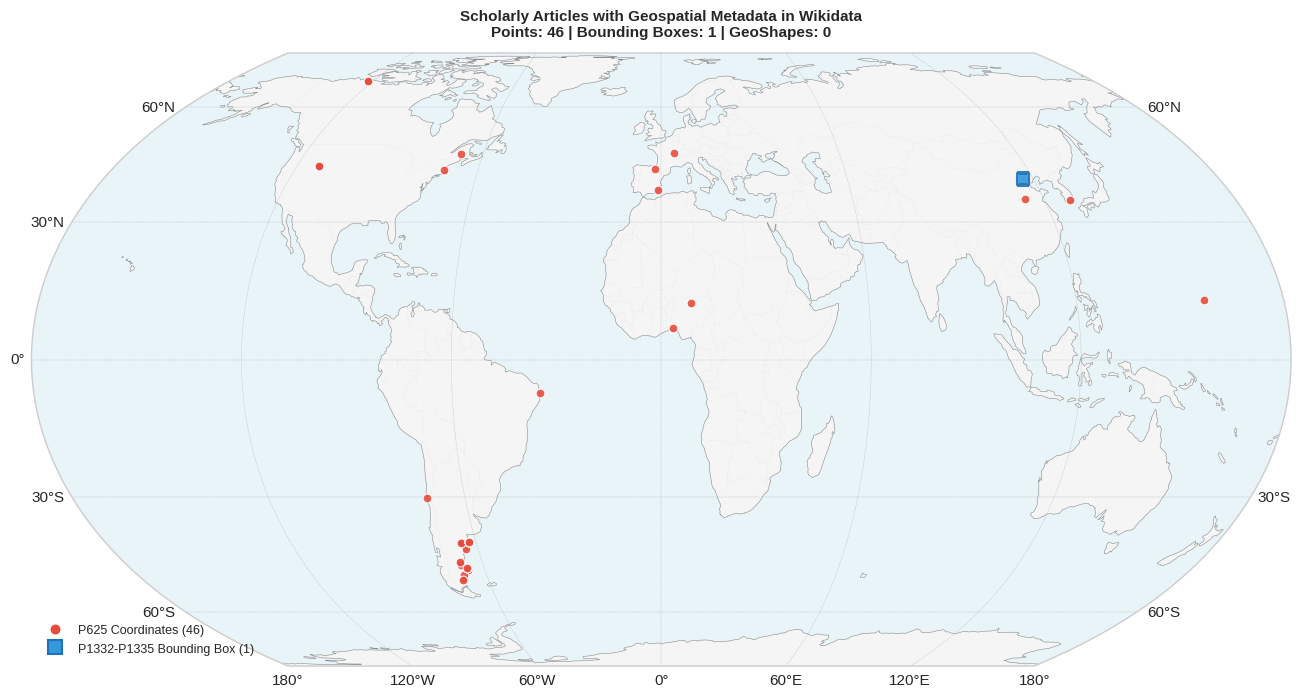

In [27]:
# Visualization: World map of scholarly articles with geospatial metadata
# Uses Cartopy with Equal Earth (equal-area) projection

try:
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
    from shapely.geometry import Point, box
    import geopandas as gpd
    import numpy as np
    CARTOPY_AVAILABLE = True
except ImportError:
    CARTOPY_AVAILABLE = False
    print("Cartopy not available - skipping map visualization")

if CARTOPY_AVAILABLE:
    # Fetch all geometries from Wikidata
    all_geoms = kh.get_all_scholarly_geometries(limit=500)
    
    if all_geoms:
        # Create GeoDataFrame
        gdf = kh.create_geometry_geodataframe(all_geoms)
        
        if gdf is not None and len(gdf) > 0:
            # Separate by geometry type
            points_gdf = gdf[gdf['geom_type'] == 'point']
            bbox_gdf = gdf[gdf['geom_type'] == 'bbox']
            shape_gdf = gdf[gdf['geom_type'] == 'geoshape']
            
            # Equal Earth projection (modern equal-area)
            projection = ccrs.EqualEarth()
            
            fig = plt.figure(figsize=(14, 7))
            ax = fig.add_subplot(1, 1, 1, projection=projection)
            ax.set_global()
            
            # Basemap features
            ax.add_feature(cfeature.LAND, facecolor='#f5f5f5', edgecolor='none')
            ax.add_feature(cfeature.OCEAN, facecolor='#e8f4f8')
            ax.add_feature(cfeature.COASTLINE, linewidth=0.4, edgecolor='#888888')
            ax.add_feature(cfeature.BORDERS, linewidth=0.2, edgecolor='#cccccc', linestyle=':')
            
            # Plot bounding boxes - polygon + centroid marker for visibility
            if len(bbox_gdf) > 0:
                bbox_lons = []
                bbox_lats = []
                for idx, row in bbox_gdf.iterrows():
                    geom = row.geometry
                    # Draw the polygon (may be too small to see at global scale)
                    ax.add_geometries([geom], crs=ccrs.PlateCarree(),
                                     facecolor='#3498db', alpha=0.4,
                                     edgecolor='#2171b5', linewidth=2)
                    # Collect centroid for marker
                    centroid = geom.centroid
                    bbox_lons.append(centroid.x)
                    bbox_lats.append(centroid.y)
                
                # Add square markers at centroids (always visible at any scale)
                ax.scatter(bbox_lons, bbox_lats, transform=ccrs.PlateCarree(),
                          c='#3498db', s=80, zorder=4, marker='s',
                          edgecolor='#2171b5', linewidth=1.5, alpha=0.9)
            
            # Plot geoshapes - polygon + centroid marker
            if len(shape_gdf) > 0:
                shape_lons = []
                shape_lats = []
                for idx, row in shape_gdf.iterrows():
                    geom = row.geometry
                    ax.add_geometries([geom], crs=ccrs.PlateCarree(),
                                     facecolor='#9b59b6', alpha=0.4,
                                     edgecolor='#7b4397', linewidth=2)
                    centroid = geom.centroid
                    shape_lons.append(centroid.x)
                    shape_lats.append(centroid.y)
                
                # Diamond markers for geoshapes
                ax.scatter(shape_lons, shape_lats, transform=ccrs.PlateCarree(),
                          c='#9b59b6', s=80, zorder=4, marker='d',
                          edgecolor='#7b4397', linewidth=1.5, alpha=0.9)
            
            # Plot points (circles)
            if len(points_gdf) > 0:
                lons = [p.x for p in points_gdf.geometry]
                lats = [p.y for p in points_gdf.geometry]
                ax.scatter(lons, lats, transform=ccrs.PlateCarree(),
                          c='#e74c3c', s=40, zorder=5, marker='o',
                          edgecolor='white', linewidth=0.8, alpha=0.9)
            
            # Gridlines
            gl = ax.gridlines(draw_labels=True, linewidth=0.3, color='gray',
                             alpha=0.5, linestyle='--')
            gl.top_labels = False
            gl.right_labels = False
            
            # Title (use text instead of Unicode symbols to avoid font warnings)
            ax.set_title(
                f'Scholarly Articles with Geospatial Metadata in Wikidata\n'
                f'Points: {len(points_gdf)} | Bounding Boxes: {len(bbox_gdf)} | GeoShapes: {len(shape_gdf)}',
                fontsize=11, fontweight='bold', pad=12
            )
            
            # Legend with markers (matplotlib handles these without Unicode issues)
            from matplotlib.lines import Line2D
            legend_elements = []
            if len(points_gdf) > 0:
                legend_elements.append(Line2D([0], [0], marker='o', color='w',
                                             markerfacecolor='#e74c3c', markersize=8,
                                             markeredgecolor='white', markeredgewidth=0.8,
                                             label=f'P625 Coordinates ({len(points_gdf)})'))
            if len(bbox_gdf) > 0:
                legend_elements.append(Line2D([0], [0], marker='s', color='w',
                                             markerfacecolor='#3498db', markersize=10,
                                             markeredgecolor='#2171b5', markeredgewidth=1.5,
                                             label=f'P1332-P1335 Bounding Box ({len(bbox_gdf)})'))
            if len(shape_gdf) > 0:
                legend_elements.append(Line2D([0], [0], marker='d', color='w',
                                             markerfacecolor='#9b59b6', markersize=10,
                                             markeredgecolor='#7b4397', markeredgewidth=1.5,
                                             label=f'P3896 GeoShape ({len(shape_gdf)})'))
            
            if legend_elements:
                ax.legend(handles=legend_elements, loc='lower left', 
                         fontsize=9, framealpha=0.95)
            
            plt.tight_layout()
            #plt.savefig('geospatial_map.pdf', dpi=150, bbox_inches='tight', facecolor='white')
            plt.show()
            
            display(HTML(
                '<p style="font-size: 0.9em; color: #666;"><em>'
                'Figure 3: Global distribution of scholarly articles with geospatial metadata. '
                'Small polygons (bounding boxes, geoshapes) are marked with symbols at their centroids for visibility. '
                'Note: The bounding box in Mongolia/China region has incorrect coordinates in Wikidata (should be in Nevada, USA).'
                '</em></p>'
            ))
        else:
            display(Markdown('*No valid geometries could be created from the Wikidata results.*'))
    else:
        display(Markdown('*No scholarly articles with geospatial properties found in Wikidata.*'))
else:
    display(Markdown(
        '*Map visualization requires cartopy and geopandas. '
        'Install with: `pip install cartopy geopandas`*'
    ))

In [28]:
# Fetch geospatial/temporal stats per partner journal with metadata (hidden - data fetching)
# This queries each journal for articles with geo/temporal properties and enhances with ISSN/publisher

journal_geo_stats = []

for journal in partner_journals:
    qid = journal["wikidata_qid"]
    name = journal["name"]
    
    # Get metadata from Wikidata (ISSN, publisher)
    meta = kh.get_journal_metadata_wikidata(qid)
    
    # Get geospatial/temporal counts
    coords = kh.count_journal_articles_with_coordinates(qid)
    bbox = kh.count_journal_articles_with_bounding_box(qid)
    geoshape = kh.count_journal_articles_with_geoshape(qid)
    temporal = kh.count_journal_articles_with_temporal_scope(qid)
    geo_subj = kh.count_journal_articles_with_geographic_subject(qid)
    
    # Try Crossref for publisher if not in Wikidata
    publisher = meta.get("publisher")
    publisher_src = "wikidata" if publisher else None
    if not publisher and meta.get("issn"):
        cr_meta = kh.get_journal_metadata_crossref(meta["issn"])
        if cr_meta and cr_meta.get("publisher"):
            publisher = cr_meta["publisher"]
            publisher_src = "crossref"
    
    journal_geo_stats.append({
        "name": name,
        "qid": qid,
        "issn": meta.get("issn"),
        "publisher": publisher,
        "publisher_source": publisher_src,
        "total_articles": next((s["wikidata_articles"] for s in journal_stats if s["qid"] == qid), 0),
        "with_coordinates": coords or 0,
        "with_bounding_box": bbox or 0,
        "with_geoshape": geoshape or 0,
        "with_temporal_scope": temporal or 0,
        "with_geo_subject": geo_subj or 0
    })
    
    time.sleep(0.5)  # Rate limiting

In [29]:
# Display journal geospatial/temporal properties table
df_journal_geo = pd.DataFrame([{
    'Journal': s['name'][:35] + ('...' if len(s['name']) > 35 else ''),
    'ISSN': s['issn'] or '—',
    'Publisher': (s['publisher'][:25] + '...' if s['publisher'] and len(s['publisher']) > 25 else s['publisher']) or '—',
    'Articles': s['total_articles'],
    'P625': s['with_coordinates'],
    'Bbox': s['with_bounding_box'],
    'Shape': s['with_geoshape'],
    'Temporal': s['with_temporal_scope'],
    'Geo Subj': s['with_geo_subject']
} for s in journal_geo_stats])

# Calculate totals
total_with_any_geo = sum(1 for s in journal_geo_stats if s['with_coordinates'] > 0 or s['with_bounding_box'] > 0 or s['with_geoshape'] > 0 or s['with_geo_subject'] > 0)
total_with_temporal = sum(1 for s in journal_geo_stats if s['with_temporal_scope'] > 0)

display(Markdown(f'''
#### Partner Journal Geospatial & Temporal Coverage

**Journals with any geospatial data:** {total_with_any_geo} | **Journals with temporal data:** {total_with_temporal}

*Columns: P625 = direct coordinates, Bbox = bounding box (P1332-P1335), Shape = geoshape/GeoJSON (P3896), Temporal = start/end time (P580/P582), Geo Subj = geographic main subject*
'''))

show_table(df_journal_geo)


#### Partner Journal Geospatial & Temporal Coverage

**Journals with any geospatial data:** 0 | **Journals with temporal data:** 0

*Columns: P625 = direct coordinates, Bbox = bounding box (P1332-P1335), Shape = geoshape/GeoJSON (P3896), Temporal = start/end time (P580/P582), Geo Subj = geographic main subject*


Journal,ISSN,Publisher,Articles,P625,Bbox,Shape,Temporal,Geo Subj
Journal of South Asian Linguistics,1947-8232,—,0,0,0,0,0,0
Free Neuropathology,2699-4445,University of Münster,0,0,0,0,0,0
Jahrbuch für Christliche Sozialwiss...,—,—,0,0,0,0,0,0
Journal für Kulturpflanzen,1867-0911,Eugen Ulmer Verlag,0,0,0,0,0,0
VITIS - Journal of Grapevine Resear...,0042-7500,Julius Kühn-Institut,0,0,0,0,0,0
Journal of Applied Botany and Food ...,0066-1759,Section Applied Botany of...,0,0,0,0,0,0
Francia-Recensio,2425-3510,German Historical Institu...,0,0,0,0,0,0
Heidelberger Beiträge zum Finanz- u...,—,—,0,0,0,0,0,0
Informationspraxis,2297-3249,Heidelberg University Lib...,28,0,0,0,0,0
International Journal of Dream Rese...,1866-7953,—,0,0,0,0,0,0


### 5.3 Discussion

Wikidata contains ~41 million scholarly articles ([Q13442814](https://www.wikidata.org/wiki/Q13442814)). The extremely low counts above demonstrate the opportunity for the approaches developed in KOMET to contribute geospatial metadata to the commons. In particular, the statistics above reveal a the following significant gaps:

- **Less than 50 articles** out of ~41 million have direct coordinate data (P625)
- **Very few articles** use bounding box properties (P1332-P1335) to define study areas
- **Subject-based linking** (P921 → geo item) for geographic entities is scarcely used
- **GeoShape (P3896)** for complex geometries is virtually unused
- **Temporal scope metadata** (P580/P582) for study periods is equally rare

This represents a major opportunity for KOMET, via the geoMetadata plugins for OJS and Janeway for collection and display, and through OPTIMAP for crowdsourcing and curation, to contribute meaningful geospatial enrichment to the scholarly metadata commons.
The [OPTIMAP portal](https://optimap.science/) and its [Wikidata export functionality](https://github.com/GeoinformationSystems/optimap/blob/main/works/wikidata.py) use a comprehensive model:

1. **Center coordinates** (P625) for point locations
2. **Bounding box** (P1332-P1335) for spatial extent
3. **Temporal scope** (P580/P582) for research time periods
4. **Export marker** in item description for tracking contributions

**Note**: P3896 (geoshape) could be used for complex study area boundaries as GeoJSON files on Wikimedia Commons, but this is not currently part of the OPTIMAP export model.

As journals adopt the KOMET geoMetadata plugins and OPTIMAP collects these data and export them to Wikidata, the baseline numbers and methods in this notebook will allow to measure the growth in geospatially-annotated scholarly articles, track KOMET contributions specifically, and demonstrate the project's impact on the metadata commons.


In [30]:
# Add geospatial stats to report data and save (hidden)
report_data["geospatial"] = {
    "direct_coordinates_p625": geo_stats["direct_coordinates_p625"],
    "bounding_box_p1332_p1335": geo_stats["bounding_box_p1332_p1335"],
    "geoshape_p3896": geo_stats["geoshape_p3896"],
    "geographic_main_subject": geo_stats["geographic_main_subject"],
    "temporal_start_p580": geo_stats["temporal_start_p580"],
    "temporal_end_p582": geo_stats["temporal_end_p582"],
    "properties_tracked": {
        "P625": "coordinate location",
        "P1332": "northernmost point",
        "P1333": "southernmost point", 
        "P1334": "easternmost point",
        "P1335": "westernmost point",
        "P3896": "geoshape (GeoJSON polygon/line)",
        "P921": "main subject (linked to geo items)",
        "P580": "start time",
        "P582": "end time"
    },
    "notes": "Data from scholarly-specific Wikidata endpoint (query-scholarly.wikidata.org)"
}

# Add journal geospatial stats to report data
report_data["journal_geospatial"] = journal_geo_stats

# Save timeline with all metrics including geospatial
kh.save_timeline(timeline)
kh.save_json(report_data, "komet_report_data.json")

---

## Status and Next Steps

The notebook is able to run automatically on a monthly basis via [GitHub Actions](https://github.com/GeoinformationSystems/komet-report/actions). This allows tracking progress over time as KOMET plugins are adopted by journals and as the OJS core's citations feature is utilized by more and more OJS instances.
The workflow establishes a baseline for future comparison, not only for Wikidata but also for OpenCitations contributions.
The data included in this report is saved as machine readable data files (JSON) in the repository for future uptake by other tools or analyses.

Ideas for future work are captures in the open development repository on GitHub: <https://github.com/GeoinformationSystems/komet-report/>.

---

## License & Data Sources

### This Notebook

**Code**: [![CC0](https://licensebuttons.net/p/zero/1.0/88x31.png)](https://creativecommons.org/publicdomain/zero/1.0/) [CC0 1.0 Universal](https://creativecommons.org/publicdomain/zero/1.0/)

**Report outputs**: [![CC-BY](https://licensebuttons.net/l/by/4.0/88x31.png)](https://creativecommons.org/licenses/by/4.0/) [CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/)

### External Data Sources

| Source | License | Terms |
|--------|---------|-------|
| **Wikidata** | CC0 1.0 | [Wikidata Licensing](https://www.wikidata.org/wiki/Wikidata:Licensing) |
| **OpenCitations** | CC0 1.0 | [OpenCitations Licensing](https://opencitations.net/about#licensing) |

### Citation

```bibtex
@software{komet_report,
  author = {KOMET Project Team},
  title = {KOMET Evaluation Report: Tracking Open Metadata Contributions},
  url = {https://github.com/TIBHannover/komet-report},
  year = {2024-2025}
}
```